In [36]:
# Importacion de librerias
import configAPI
import datetime
import mysql.connector
import requests

import datetime as dt
import numpy as np
import pandas as pd
import json
from   pandas.io.json import json_normalize
import seaborn as sb
import matplotlib.pyplot as plt
from   matplotlib.cbook import boxplot_stats
from  sklearn.preprocessing import StandardScaler
from  sklearn.decomposition import PCA

# .:INFORMACIÓN SOBRE MÓDULO:.
El presente módulo utiliza datos descargados de la API ***Dark Sky*** (documentación: https://darksky.net/dev/docs ), basados en los parámetros seteados
por el archivo ***configAPI***. La elección de los parámetros permite, en este caso, obtener información meteorológica de Teodelina de los años 2015 y 2016.

De precisar una nueva descarga de datos:
1. Actualizar el archivo ***configAPI*** con el ***token*** otorgado por la página y las **coordenadas** del lugar (si se tratase de un nuevo objetivo) 
2. Setear a ***True*** la variable **descarga**
3. Renombrar (recomendado) la variable **nombre_json**, con el fin de conservar el archivo existente
4. Modificar la lista **años** (en caso de ser necesario)

# .:INFORMACIÓN GENERAL DE LA CONSULTA:.
La obtención de los datos radica en ejecutar una solicitud a la API basada en la información contenida en la *url* de la consulta.
En este trabajo, la *url* presenta la siguiente estructura:

---
---

https://api.darksky.net/forecast/key/latitude,longitude,date?exclude=flags,hourly&units=ca

---
---
donde:
- ***latitude*** y ***longitude*** son las coordenadas geográficas del lugar de interés
- ***date*** es la fecha y hora en formato *timestamp*
- ***exclude*** deshabilita la descarga de los bloques que se listan luego del símbolo de igualdad
- ***units*** establece el sistema de unidades que se utilizará sobre los datos, en este caso ***ca*** es similar al sistema ***si*** exceptuando *windSpeed* y *windGust* que están en kilómetros por hora.

Luego de ejecutar la solicitud se obtiene la siguiente infotmación en formato json:

![Salida Api](json.png)

En este trabajo se utilizarán datos del bloque ***currently*** (*time* y *temperature*) y ***daily*** (*time*, *summary*, *humidity*, *pressure*, *windBearing*, *uvIndex*, *temperatureMin*, *temperatureMax*)

## .::Primera Parte: Carga de Datos::.

In [2]:
meses = np.arange(1,13,1)              # meses en numero.
diasXmes = {1:31,                      # diccionario de dias por mes, durante la descarga de datos ---
            2:28,                      # se agrega condicion sobre febrero si es bisiesto
            3:31,
            4:30,
            5:31,
            6:30,
            7:31,
            8:31,
            9:30,
            10:31,
            11:30,
            12:31
           }

mesString = {1:'ENERO',               # diccionario numero mes vs nombre del mes
             2:'FEBRERO',
             3:'MARZO',
             4:'ABRIL',
             5:'MAYO',
             6:'JUNIO',
             7:'JULIO',
             8:'AGOSTO',
             9:'SEPTIEMBRE',
             10:'OCTUBRE',
             11:'NOVIEMBRE',
             12:'DICIEMBRE'
            }

In [3]:
descargar = False
nombre_json = 'json_.txt' # se recomienda modificar nombre_json si va a realizar una nueva descarga

In [4]:
# solicitud de datos para los años de la consigna
if descargar==True:
    baseUrl = "https://api.darksky.net/forecast/<key>/<latitude>,<longitude>,<date>?exclude=flags,hourly&units=ca"
    jasons = []
    años = [2015,2016] # años consigna. Modificar en caso de ser necesario
    for año in años:
        for mes in meses:
            print('\n\n***********************MES: ',mesString[mes])
            if año%4==0 and mes==2:
                dias = 29
                #print(dias,mes,año,'soy bisisesto')
            else:
                dias = diasXmes[mes]
                #print(dias,mes,año)
            for dia in np.arange(1,dias+1,1):
                print(dia,mes,año)
                date = dt.datetime(año,mes,dia,23,59)
                date_timestamp = int(dt.datetime.timestamp(date)) 
                replacedUrl = baseUrl.replace("<key>", configAPI.API_KEY).replace("<latitude>", str(config.TEODELINA_LAT)).replace("<longitude>", str(config.TEODELINA_LONG)).replace("<date>",str(int(date_timestamp)))
                r = requests.get(url = replacedUrl) 
                jasons.append(r.json())

    with open(nombre_json, 'w') as file:
        file.write(json.dumps(jasons))

In [5]:
# se cargan los datos
with open(nombre_json) as archivo:
    json_data = json.load(archivo)

In [6]:
datos_solicitados = ['time','summary','humidity','pressure','windBearing','uvIndex','temperatureMin','temperatureMax']
datos = {}               # diccionario que almacena el valor de cada variable solicitada
dbDatos = pd.DataFrame() # dataframe de los datos

# creacion de dataframe
for i in range(len(json_data)):
    timeC = json_data[i]['currently']['time']
    datos.update({'timeC':timeC})  # hora de tempreratura actual
    try:
        temperature = json_data[i]['currently']['temperature']
        datos.update({'temperature':temperature})
    except:
        temperature = np.nan
        datos.update({'temperature':temperature})
    if 'daily' in json_data[i].keys():
        datos_del_dia = list(json_data[i]['daily']['data'][0].keys())
        faltantes     = list(set(datos_solicitados)-set(datos_del_dia))
        existentes    = list(set(datos_solicitados)-set(faltantes))
        for existente in range(len(existentes)):
            datos.update({existentes[existente]:json_data[i]['daily']['data'][0][existentes[existente]]})
        for faltante in range(len(faltantes)):
            if faltantes[faltante]=='summary':
                datos.update({faltantes[faltante]:np.nan})
            else:
                datos.update({faltantes[faltante]:np.nan})
    else:
        for solicitados in range(len(datos_solicitados)):
            if datos_solicitados[solicitados]=='summary':
                datos.update({datos_solicitados[solicitados]:np.nan})
            else:
                datos.update({datos_solicitados[solicitados]:np.nan})
    dbDatos = dbDatos.append(datos,ignore_index=True)

## .::Segunda Parte: Outliers Y Datos Nulos::.

In [7]:
dbDatos_sin_bloque_daily = dbDatos[dbDatos.time.isna()==True]
dbDatos_con_bloque_daily = dbDatos[dbDatos.time.isna()==False]

tot_datos_sin_daily = len(dbDatos_sin_bloque_daily)
tot_datos_con_daily = len(dbDatos_con_bloque_daily)
print('Cantidad de días que NO contienen al bloque Daily: ',tot_datos_sin_daily,'\nCantidad de días que SÍ contienen al bloque Daily: ',tot_datos_con_daily)

Cantidad de días que NO contienen al bloque Daily:  49 
Cantidad de días que SÍ contienen al bloque Daily:  682


### OUTLIERS:

In [8]:
estadisticos = dbDatos.describe()
estadisticos

,humidity,pressure,temperature,temperatureMax,temperatureMin,time,timeC,uvIndex,windBearing
count,678.000000,671.000000,720.000000,678.000000,678.000000,6.820000e+02,7.310000e+02,682.000000,677.000000
mean,0.739985,1015.419911,19.595111,21.968894,10.969735,1.451201e+09,1.451660e+09,4.799120,128.471196
std,0.109389,5.986913,6.372183,6.332503,5.724783,1.828419e+07,1.824473e+07,2.755712,97.926964
min,0.360000,997.890000,6.210000,9.210000,-3.910000,1.420081e+09,1.420124e+09,0.000000,0.000000
25%,0.670000,1011.085000,14.210000,17.010000,6.610000,1.435309e+09,1.435892e+09,2.000000,42.000000
50%,0.740000,1015.160000,19.210000,22.020000,11.005000,1.450796e+09,1.451660e+09,4.000000,112.000000
75%,0.820000,1019.315000,24.632500,27.200000,15.810000,1.467234e+09,1.467428e+09,7.000000,193.000000
max,0.980000,1035.290000,33.500000,35.610000,22.910000,1.482894e+09,1.483196e+09,11.000000,359.000000


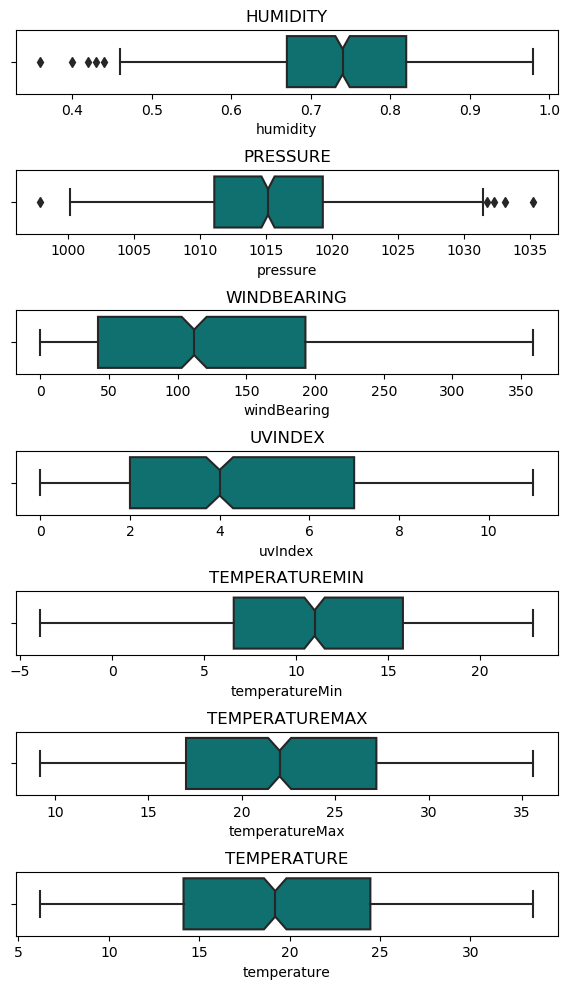

In [9]:
plt.figure(figsize=(7,12),dpi=100)
datos = ['humidity','pressure','windBearing','uvIndex','temperatureMin','temperatureMax','temperature']
nplots = len(datos)
outliers = {}
j = 1
db = dbDatos_con_bloque_daily.copy()
for variable in datos:
    plt.subplot(nplots,1,j)
    sb.boxplot(db[variable],notch=True,color='teal')
    plt.title(variable.upper())
    q1 = estadisticos[variable]['25%']
    q3 = estadisticos[variable]['75%']
    iq = 1.5*(q3-q1)
    linf = q1-iq
    lsup = q3+iq
    atipicos = db[((db[variable]>=linf)&(db[variable]<=lsup)==False)]
    atipicos = atipicos[atipicos[variable].isna()==False]
    outliers.update({variable:atipicos[variable].values})   
    j+=1
plt.subplots_adjust(hspace=1.2)

In [10]:
outliers

{'humidity': array([0.43, 0.4 , 0.42, 0.36, 0.44]),
 'pressure': array([1031.79,  997.89, 1032.31, 1035.29, 1033.12]),
 'windBearing': array([], dtype=float64),
 'uvIndex': array([], dtype=float64),
 'temperatureMin': array([], dtype=float64),
 'temperatureMax': array([], dtype=float64),
 'temperature': array([], dtype=float64)}

#### COMENTARIOS SOBRE VALORES ATÍPICOS:
1. De las siete variables numéricas bajo estudio, sólo dos presentan valores atípicos: *humidity* y *pressure*
2. Los valores que toman los *outliers* representan menos del 1% de los datos de cada variable.
3. Los gráficos de caja de las variables que poseen *outliers*, evidencian valores atípicos cercanos a la frontera de valores típicos.

Ergo, al ser pocos y al estar cerca de los valores típicos, no tiene sentido eliminarlos, pues no generan peso sobre los valores de centralización ni en la dispersión.

### VALORES NULOS
#### CRITERIOS DE RELLENO:
1. Para la variable *time* se utiliza la variable *timeC* (tiempo del bloque *currently*), e.i., el tiempo cargado en la *url* de la consulta. Así, cuando el bloque *daily* no está presente y por lo tanto no se tienen los datos de dicho bloque como: *time*, se setea este último por el valor de *timeC*.  
2. Se utiliza el método de interpolación lineal para las variables numéricas continuas.
3. Para el caso de la variable categórica nominal *summary*, se utiliza una clasificación artesanal. Dicha clasificación utiliza el método de componentes principales (*PCA*) sobre las variables numéricas continuas no temporales. Pasos:
  - Estandarizarización de variables. 
  - Generación de componentes principales, en este caso dos: **CP1** y **CP2**
  - Categorización de las nuevas variables. En este caso se utilizaron cinco rangos equiespaciados.
  - Confección de tabla cruzada: *summary* vs. variables nuevas categóricas.
  - Establecimiento manual de criterios de asignación. 

In [11]:
# relleno de nulos en variable time del bloque daily
dbDatos.loc[dbDatos.time.isna(),'time'] = dbDatos.loc[dbDatos.time.isna()].timeC
dbDatos.loc[dbDatos.time.isna(),'time'] 

Series([], Name: time, dtype: float64)

In [12]:
# Se convierten valores de tiempo timestamp a datetime
dbDatos.loc[dbDatos.timeC.isna()==False,'timeC_dt'] = dbDatos[dbDatos.timeC.isna()==False].timeC.apply(lambda x: dt.datetime.fromtimestamp(int(x)))
dbDatos.loc[dbDatos.time.isna()==False,'time_dt'] = dbDatos[dbDatos.time.isna()==False].time.apply(lambda x: dt.datetime.fromtimestamp(int(x)))

In [14]:
# veamos cuantos nulos tenemos antes de interpolar
for columna in dbDatos.columns:
    print(columna+' nulos: ', len(dbDatos[dbDatos[columna].isna()]))

humidity nulos:  53
pressure nulos:  60
summary nulos:  49
temperature nulos:  11
temperatureMax nulos:  53
temperatureMin nulos:  53
time nulos:  0
timeC nulos:  0
uvIndex nulos:  49
windBearing nulos:  54


In [15]:
# relleno de variables numericas continuas por interpolacion
dbRelleno = dbDatos.interpolate(method ='linear', limit_direction ='forward',limit = 4)

In [16]:
# nulos despues de interpolar
for columna in dbDatos.columns:
    print(columna+' nulos: ', len(dbRelleno[dbRelleno[columna].isna()]))

humidity nulos:  0
pressure nulos:  0
summary nulos:  49
temperature nulos:  0
temperatureMax nulos:  0
temperatureMin nulos:  0
time nulos:  0
timeC nulos:  0
uvIndex nulos:  0
windBearing nulos:  0


In [17]:
# variables a utilizar para PCA
columnas= ['humidity', 'pressure', 'temperature', 'temperatureMax','temperatureMin', 'uvIndex', 'windBearing']

In [18]:
# estandarizacion
variables_pca = dbRelleno.loc[:, columnas].values
target = dbRelleno.loc[:,['summary']].values
estadarizados = StandardScaler().fit_transform(variables_pca)

In [19]:
# reduccion de dimensionalidad a dos componentes principales
pca = PCA(n_components=2)
componentes_principales = pca.fit_transform(estadarizados)
dbPrincipales = pd.DataFrame(data=componentes_principales,columns = ['CP1', 'CP2'])

In [20]:
estadisticos = dbPrincipales.describe()
estadisticos

,CP1,CP2
count,7.310000e+02,7.310000e+02
mean,-3.948810e-17,9.416392e-18
std,1.936671e+00,1.128708e+00
min,-4.339297e+00,-3.083735e+00
25%,-1.529626e+00,-8.183818e-01
50%,-3.347663e-02,-8.360028e-02
75%,1.616133e+00,7.267466e-01
max,4.370804e+00,3.297411e+00


In [21]:
dbPrincipalesFinal = pd.concat([dbPrincipales, dbRelleno[['summary']]], axis = 1)
dbPrincipalesFinal.head()

,CP1,CP2,summary
0,-0.778196,0.363739,Mostly cloudy throughout the day.
1,-1.108751,1.964094,Clear throughout the day.
2,-1.997096,0.566976,Partly cloudy throughout the day.
3,-1.684769,0.395353,Clear throughout the day.
4,-3.129522,-0.273484,Partly cloudy throughout the day.


In [22]:
# categorizacion de las componentes principales a cinco rangos ordinales
categorias = {}
columnas = []
ncat = 5
for columna in estadisticos.columns:
    minimo = estadisticos[columna]['min']
    maximo = estadisticos[columna]['max']
    categorias.update({columna:[round(minimo+i*(maximo-minimo)/ncat,2) for i in np.arange(0,ncat+1,1)]})
    columnas.append(columna)

In [23]:
for columna in columnas:
    dbPrincipalesFinal[columna+'_cat'] = pd.cut(dbPrincipalesFinal[columna], bins=categorias[columna], include_lowest=True, labels=['cat5','cat4','cat3','cat2','cat1'] )

In [24]:
# generacion de tabla cruzada
cross = pd.crosstab(dbPrincipalesFinal.summary, [dbPrincipalesFinal.CP1_cat,dbPrincipalesFinal.CP2_cat])

In [25]:
#with pd.ExcelWriter('cross.xlsx') as writer:
#    cross.to_excel(writer)

In [26]:
# columna de categorias combinadas
dbPrincipalesFinal['id_dict'] = dbPrincipalesFinal.CP1_cat.astype(str)+'-'+dbPrincipalesFinal.CP2_cat.astype(str)

In [27]:
dic_summary={   1:'Clear throughout the day.'                  ,                           
                2:'Foggy in the afternoon.'                    ,                     
                3:'Foggy in the morning.'                      ,                      
                4:'Humid and mostly cloudy throughout the day.',                                    
                5:'Humid and overcast throughout the day.'     ,                                 
                6:'Humid and partly cloudy throughout the day.',                                
                7:'Humid throughout the day.'                  ,                            
                8:'Mostly cloudy throughout the day.'          ,                                  
                9:'Overcast throughout the day.'               ,                                
                10:'Partly cloudy throughout the day.'         ,                                                
                11:'Windy in the afternoon.'                   ,                       
                12:'Windy in the evening.'                      
            }        


In [28]:
asignacion ={   'cat5-cat5':4,
                'cat5-cat4':5,
                'cat5-cat3':6,
                'cat5-cat2':1,
                'cat5-cat1':1,
                'cat4-cat5':4,
                'cat4-cat4':7,
                'cat4-cat3':8,
                'cat4-cat2':10,
                'cat4-cat1':10,
                'cat3-cat5':9,
                'cat3-cat4':9,
                'cat3-cat3':12,
                'cat3-cat2':10,
                'cat3-cat1':10,
                'cat2-cat5':11,
                'cat2-cat4':8,
                'cat2-cat3':10,
                'cat2-cat2':1,
                'cat2-cat1':3,
                'cat1-cat5':2,
                'cat1-cat4':9,
                'cat1-cat3':8,
                'cat1-cat2':10,
                'cat1-cat1':2
            }

In [29]:
# asignacion de summary segun combinacion de categorias
dbPrincipalesFinal.loc[dbPrincipalesFinal.summary.isna(),'summary'] = dbPrincipalesFinal[dbPrincipalesFinal.summary.isna()].id_dict.map(asignacion)

In [30]:
dbPrincipalesFinal.loc[dbPrincipalesFinal.summary.isin(asignacion.values()),'summary'] = dbPrincipalesFinal[dbPrincipalesFinal.summary.isin(asignacion.values())].summary.map(dic_summary)

In [31]:
# indices de valores nulos de summary
nulos_summary=dbRelleno[dbRelleno.summary.isna()].index
dbRelleno.loc[nulos_summary]

,humidity,pressure,summary,temperature,temperatureMax,temperatureMin,time,timeC,uvIndex,windBearing
46,0.765000,1013.930000,NaN,25.800,27.905000,17.105000,1.424099e+09,1.424099e+09,6.500000,67.000000
101,0.842500,1016.684000,NaN,22.420,23.450000,17.160000,1.428851e+09,1.428851e+09,4.000000,95.000000
102,0.855000,1015.848000,NaN,29.620,23.500000,17.310000,1.428937e+09,1.428937e+09,4.000000,96.000000
122,0.750000,1010.885000,NaN,15.760,18.655000,6.400000,1.430665e+09,1.430665e+09,3.500000,267.000000
149,0.836667,1015.910000,NaN,14.410,18.410000,9.010000,1.432998e+09,1.432998e+09,2.000000,144.000000
150,0.843333,1016.530000,NaN,17.310,19.010000,7.810000,1.433084e+09,1.433084e+09,2.000000,248.000000
180,0.810000,1015.650000,NaN,14.410,17.410000,8.505000,1.435676e+09,1.435676e+09,2.000000,171.000000
189,0.810000,1016.215000,NaN,11.610,15.810000,6.100000,1.436454e+09,1.436454e+09,2.000000,87.000000
215,0.745000,1013.350000,NaN,14.810,18.210000,10.105000,1.438700e+09,1.438700e+09,2.000000,113.500000
226,0.910000,1017.926667,NaN,12.710,11.210000,5.333333,1.439651e+09,1.439651e+09,3.000000,254.000000


In [32]:
# relleno de variable summary
dbRelleno.loc[nulos_summary,'summary'] = dbPrincipalesFinal.loc[nulos_summary].summary

In [33]:
dbRelleno.loc[nulos_summary,'summary']

46               Mostly cloudy throughout the day.
101                   Overcast throughout the day.
102                      Humid throughout the day.
122              Partly cloudy throughout the day.
149              Mostly cloudy throughout the day.
150              Partly cloudy throughout the day.
180              Mostly cloudy throughout the day.
189              Mostly cloudy throughout the day.
215              Partly cloudy throughout the day.
226              Mostly cloudy throughout the day.
227              Partly cloudy throughout the day.
245                      Clear throughout the day.
293              Partly cloudy throughout the day.
344              Mostly cloudy throughout the day.
349              Mostly cloudy throughout the day.
366                      Humid throughout the day.
389              Mostly cloudy throughout the day.
398              Mostly cloudy throughout the day.
400    Humid and partly cloudy throughout the day.
405    Humid and partly cloudy 

In [34]:
# corroboramos que todos los indices que eran nulos ya no lo son
dbRelleno.loc[nulos_summary]

,humidity,pressure,summary,temperature,temperatureMax,temperatureMin,time,timeC,uvIndex,windBearing
46,0.765000,1013.930000,Mostly cloudy throughout the day.,25.800,27.905000,17.105000,1.424099e+09,1.424099e+09,6.500000,67.000000
101,0.842500,1016.684000,Overcast throughout the day.,22.420,23.450000,17.160000,1.428851e+09,1.428851e+09,4.000000,95.000000
102,0.855000,1015.848000,Humid throughout the day.,29.620,23.500000,17.310000,1.428937e+09,1.428937e+09,4.000000,96.000000
122,0.750000,1010.885000,Partly cloudy throughout the day.,15.760,18.655000,6.400000,1.430665e+09,1.430665e+09,3.500000,267.000000
149,0.836667,1015.910000,Mostly cloudy throughout the day.,14.410,18.410000,9.010000,1.432998e+09,1.432998e+09,2.000000,144.000000
150,0.843333,1016.530000,Partly cloudy throughout the day.,17.310,19.010000,7.810000,1.433084e+09,1.433084e+09,2.000000,248.000000
180,0.810000,1015.650000,Mostly cloudy throughout the day.,14.410,17.410000,8.505000,1.435676e+09,1.435676e+09,2.000000,171.000000
189,0.810000,1016.215000,Mostly cloudy throughout the day.,11.610,15.810000,6.100000,1.436454e+09,1.436454e+09,2.000000,87.000000
215,0.745000,1013.350000,Partly cloudy throughout the day.,14.810,18.210000,10.105000,1.438700e+09,1.438700e+09,2.000000,113.500000
226,0.910000,1017.926667,Mostly cloudy throughout the day.,12.710,11.210000,5.333333,1.439651e+09,1.439651e+09,3.000000,254.000000


In [35]:
for columna in dbDatos.columns:
    print(columna+' nulos: ', len(dbRelleno[dbRelleno[columna].isna()]))

humidity nulos:  0
pressure nulos:  0
summary nulos:  0
temperature nulos:  0
temperatureMax nulos:  0
temperatureMin nulos:  0
time nulos:  0
timeC nulos:  0
uvIndex nulos:  0
windBearing nulos:  0
